# Submission 4 from <a href="http://petroanalytix.com/">PetroAnalytix Team</a>

In this notebook, we try NN with several ideas/code from other contestant:
* Alan Richardson (Ausar Geophysical) - PE imputation, method changed using MLPRegressor
* <a href="https://home.deib.polimi.it/bestagini/">Paolo Bestagini</a> - Feature augmentation

In [1]:
import numpy as np
np.random.seed(1337)

import warnings
warnings.filterwarnings("ignore")

import time as tm

import pandas as pd

from keras.models import Sequential, Model
from keras.constraints import maxnorm
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

Using Theano backend.


## Load dataset

In [2]:
training_data = pd.read_csv('../data/facies_vectors.csv')

### Utilities function

In [3]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]])


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [4]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [5]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '.g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '.')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '.', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '.', color='r')
    ax[4].plot(logs.PE, logs.Depth, '.', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

## Extract data

In [6]:
X = training_data.drop(['Formation', 'Well Name', 'Depth', 'Facies', 'FaciesLabels'], axis=1).values
y = training_data['Facies'].values - 1

wells = training_data["Well Name"].values

### Modified imputation method using MLPRegressor

In [7]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor()
DataImpAll = training_data.drop(['Formation', 'Well Name', 'Depth', 'FaciesLabels'], axis=1).copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))

In [8]:
training_data.ix[:,"PE"] = X[:,4]

### Feature Augmentation method from Bestagini

In [9]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [10]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [11]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [12]:
# Marine Models

Org_data = training_data
training_data = training_data[training_data["NM_M"]==1]

X = training_data.drop(['Formation', 'Well Name', 'Depth', 'Facies', 'FaciesLabels'], axis=1).values
y = training_data['Facies'].values - 1
wells = training_data["Well Name"].values
well = training_data['Well Name'].values
depth = training_data['Depth'].values


In [13]:
X, padded_rows = augment_features(X, well, depth, N_neig=1)
X1org = X
y1org = y

## Neural Network

In [14]:
def fDNN(in_dim, out_dim):
    
    # Model
    model = Sequential()
    model.add(Dense(152, input_dim=in_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(out_dim, activation='softmax'))

    # Compilation
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Validation with Leave One Well Out on Training Dataset

In [15]:
logo = LeaveOneGroupOut()

nb_classes = 9
epoch = 10
bats = 20

t0 = tm.time()

In [16]:
f1s_ls = []
acc_ls = []
adj_ls = []

from scipy.signal import medfilt

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    # Scaling
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_tr = scaler.transform(X[train])
    X_te = scaler.transform(X[test])

    Y_tr = np_utils.to_categorical(y[train], nb_classes)

    in_dim = len(X_tr[0])

    # Method initialization
    mlp = fDNN(in_dim, nb_classes)
            
    # Training
    mlp.fit(X_tr, Y_tr, nb_epoch=epoch, batch_size=bats, verbose=0) 
    
    # Predict
    y_hat = mlp.predict_classes(X_te, verbose=0)
    y_hat = medfilt(y_hat, kernel_size=5)
    
    try:
        f1s = f1_score(y[test], y_hat, average="weighted", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        f1s = 0

    try:
        conf = confusion_matrix(y[test], y_hat, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
        acc = f1_score(y[test], y_hat, average="micro", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        acc = 0

    try:
        acc_adj = accuracy_adjacent(conf, adjacent_facies)
    except:
        acc_adj = 0

    f1s_ls += [f1s]
    acc_ls += [acc]
    adj_ls += [acc_adj]
    print("{:>20s} f1w:{:.3f} | f1m:{:.3f} | acc_adj:{:.3f}".format(well_name, f1s, acc, acc_adj))

t1 = tm.time()
print("Avg F1w", np.average(f1s_ls)*100, "Avg F1m", np.average(acc_ls)*100, "Avg Adj", np.average(adj_ls)*100)
print((t1-t0), "seconds")

         ALEXANDER D f1w:0.817 | f1m:0.817 | acc_adj:1.000
     CHURCHMAN BIBLE f1w:0.581 | f1m:0.625 | acc_adj:0.955
      CROSS H CATTLE f1w:0.438 | f1m:0.443 | acc_adj:0.926
            KIMZEY A f1w:0.690 | f1m:0.716 | acc_adj:0.964
            LUKE G U f1w:0.498 | f1m:0.439 | acc_adj:0.919
               NEWBY f1w:0.669 | f1m:0.669 | acc_adj:1.000
               NOLAN f1w:0.672 | f1m:0.663 | acc_adj:0.918
             SHANKLE f1w:0.354 | f1m:0.416 | acc_adj:0.959
           SHRIMPLIN f1w:0.633 | f1m:0.622 | acc_adj:0.996
Avg F1w 59.4598812729 Avg F1m 60.1138004845 Avg Adj 95.9818573746
52.54600548744202 seconds


In [17]:
# Non - Marine

training_data = Org_data
training_data = training_data[training_data["NM_M"]==2]

X = training_data.drop(['Formation', 'Well Name', 'Depth', 'Facies', 'FaciesLabels'], axis=1).values
y = training_data['Facies'].values - 1
wells = training_data["Well Name"].values
well = training_data['Well Name'].values
depth = training_data['Depth'].values
X, padded_rows = augment_features(X, well, depth, N_neig=1)
X2org =X
y2org = y

In [18]:
f1s_ls = []
acc_ls = []
adj_ls = []

from scipy.signal import medfilt

for train, test in logo.split(X, y, groups=wells):
    well_name = wells[test[0]]
    
    # Scaling
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_tr = scaler.transform(X[train])
    X_te = scaler.transform(X[test])

    Y_tr = np_utils.to_categorical(y[train], nb_classes)

    in_dim = len(X_tr[0])

    # Method initialization
    mlp = fDNN(in_dim, nb_classes)
            
    # Training
    mlp.fit(X_tr, Y_tr, nb_epoch=epoch, batch_size=bats, verbose=0) 
    
    # Predict
    y_hat = mlp.predict_classes(X_te, verbose=0)
    y_hat = medfilt(y_hat, kernel_size=5)
    
    try:
        f1s = f1_score(y[test], y_hat, average="weighted", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        f1s = 0

    try:
        conf = confusion_matrix(y[test], y_hat, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
        acc = f1_score(y[test], y_hat, average="micro", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    except:
        acc = 0

    try:
        acc_adj = accuracy_adjacent(conf, adjacent_facies)
    except:
        acc_adj = 0

    f1s_ls += [f1s]
    acc_ls += [acc]
    adj_ls += [acc_adj]
    print("{:>20s} f1w:{:.3f} | f1m:{:.3f} | acc_adj:{:.3f}".format(well_name, f1s, acc, acc_adj))

t1 = tm.time()
print("Avg F1w", np.average(f1s_ls)*100, "Avg F1m", np.average(acc_ls)*100, "Avg Adj", np.average(adj_ls)*100)
print((t1-t0), "seconds")

         ALEXANDER D f1w:0.561 | f1m:0.597 | acc_adj:0.915
     CHURCHMAN BIBLE f1w:0.455 | f1m:0.510 | acc_adj:0.866
      CROSS H CATTLE f1w:0.386 | f1m:0.423 | acc_adj:0.732
            KIMZEY A f1w:0.434 | f1m:0.489 | acc_adj:0.889
            LUKE G U f1w:0.650 | f1m:0.633 | acc_adj:0.884
               NEWBY f1w:0.503 | f1m:0.516 | acc_adj:0.867
               NOLAN f1w:0.475 | f1m:0.502 | acc_adj:0.776
          Recruit F9 f1w:0.491 | f1m:0.325 | acc_adj:1.000
             SHANKLE f1w:0.610 | f1m:0.575 | acc_adj:0.876
           SHRIMPLIN f1w:0.355 | f1m:0.417 | acc_adj:0.922
Avg F1w 49.1912409205 Avg F1m 49.8706629953 Avg Adj 87.2579897995
86.84596729278564 seconds


## Applying to Test Dataset

In [19]:
Org_blind_data = pd.read_csv('../data/nofacies_data.csv')
blind_data = Org_blind_data[Org_blind_data["NM_M"]==1]

X_blind = blind_data.drop(['Formation', 'Well Name', 'Depth'], axis=1).values
well_blind = blind_data['Well Name'].values
depth_blind = blind_data['Depth'].values

X_blind, padded_rows = augment_features(X_blind, well_blind, depth_blind, N_neig=1)

In [20]:
# Scaling

scl = preprocessing.MinMaxScaler().fit(X1org)
X_train = scl.transform(X1org)
X_blind = scl.transform(X_blind)
Y_train = np_utils.to_categorical(y1org, nb_classes)

In [21]:
# Method initialization
model = fDNN(in_dim, nb_classes)

# Training
model.fit(X_train, Y_train, nb_epoch=epoch, batch_size=bats, verbose=0) 

# Predict
y_blind = model.predict_classes(X_blind, verbose=0)
y_blind = medfilt(y_blind, kernel_size=5)

Org_blind_data.ix[Org_blind_data["NM_M"]==1,"Facies"] = y_blind + 1  # return the original value (1-9)

In [22]:
blind_data = Org_blind_data[Org_blind_data["NM_M"]==2]
X_blind = blind_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
well_blind = blind_data['Well Name'].values
depth_blind = blind_data['Depth'].values
X_blind, padded_rows = augment_features(X_blind, well_blind, depth_blind, N_neig=1)

# Scaling


scl = preprocessing.MinMaxScaler().fit(X2org)
X_train = scl.transform(X2org)
X_blind = scl.transform(X_blind)

Y_train = np_utils.to_categorical(y2org, nb_classes)

# Method initialization
model = fDNN(in_dim, nb_classes)

# Training
model.fit(X_train, Y_train, nb_epoch=epoch, batch_size=bats, verbose=0) 

# Predict
y_blind = model.predict_classes(X_blind, verbose=0)
y_blind = medfilt(y_blind, kernel_size=5)

Org_blind_data.ix[Org_blind_data["NM_M"]==2,"Facies"] = y_blind + 1  # return the original value (1-9)

In [23]:
blind_data.to_csv("PA_Team_Submission_4.csv")

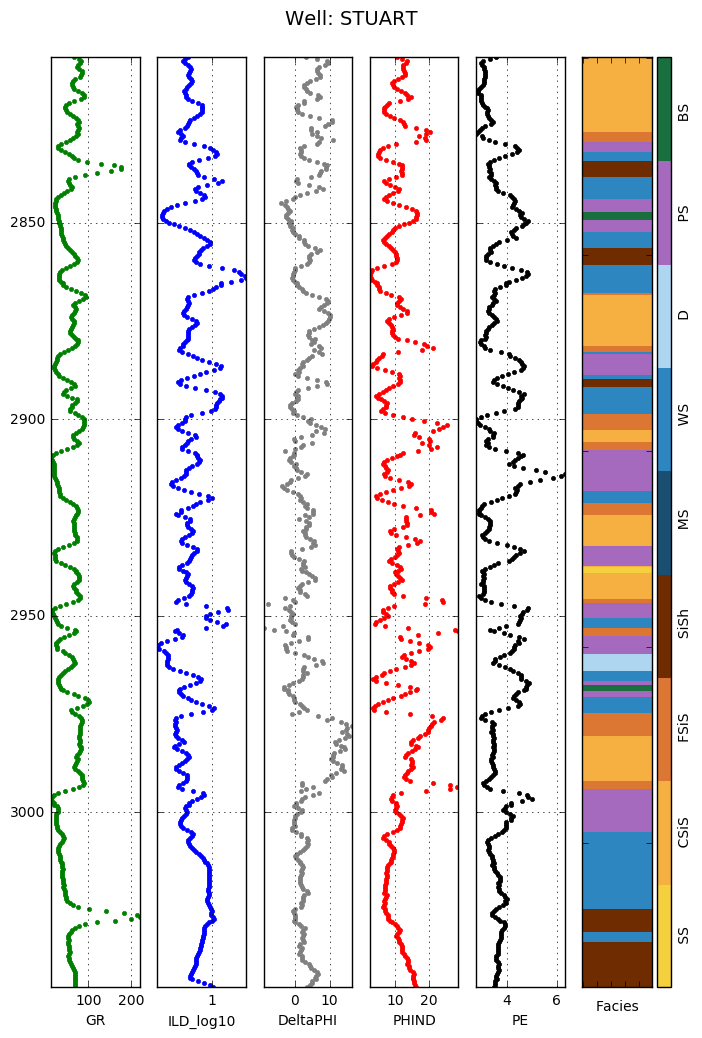

In [24]:
make_facies_log_plot(
    Org_blind_data[Org_blind_data['Well Name'] == 'STUART'],
    facies_colors)

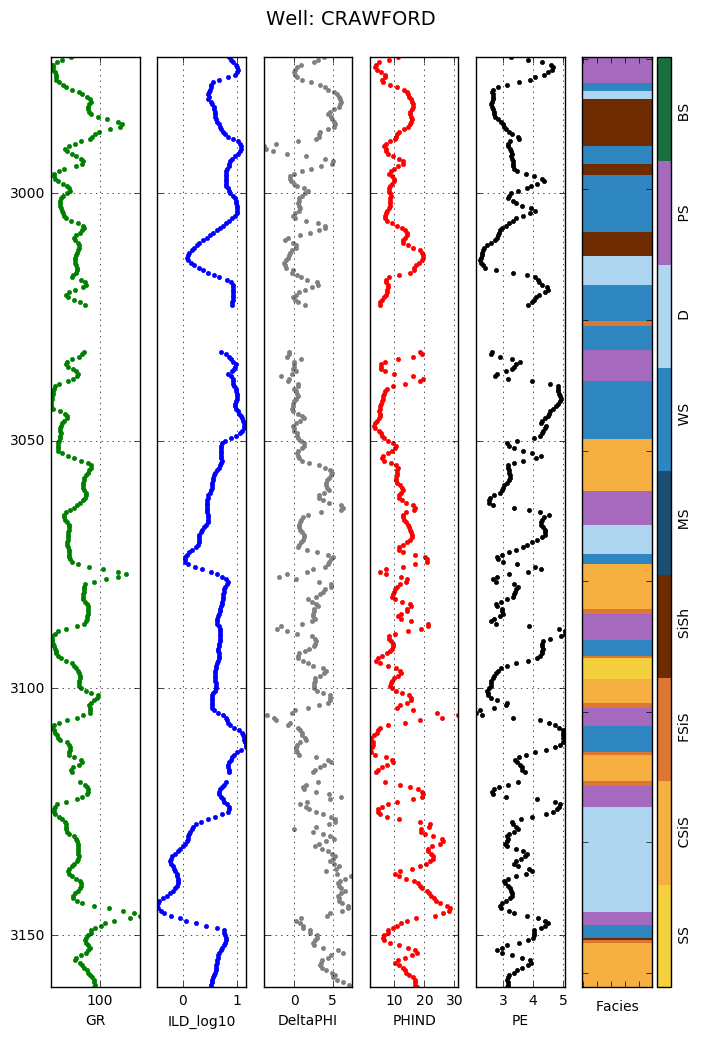

In [25]:
make_facies_log_plot(
    Org_blind_data[Org_blind_data['Well Name'] == 'CRAWFORD'],
    facies_colors)